# Installing Requirements:

In [1]:
!pip install tensorflow tensorflow_datasets opencv-python-headless matplotlib

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from skimage.metrics import structural_similarity as ssim

# Loading and Preprocessing the LFW Faces Dataset:

In [3]:
tf.random.set_seed(42)
def preprocess(sample):
    img = tf.image.resize(sample["image"], (128, 128))
    gray = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.float32) / 255.0
    gray = tf.cast(gray, tf.float32) / 255.0
    return gray, img

train_raw = tfds.load("lfw", split="train[:90%]", shuffle_files=True, download=True)
test_raw  = tfds.load("lfw", split="train[90%:]", shuffle_files=True, download=True)

train_ds = (train_raw
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(500)
            .batch(16)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_raw
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(16)
           .prefetch(tf.data.AUTOTUNE))

for gray_batch, color_batch in train_ds.take(1):
    print("Gray:", gray_batch.shape, "Color:", color_batch.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.D3I8XW_0.1.1/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.1. Subsequent calls will reuse this data.
Gray: (16, 128, 128, 1) Color: (16, 128, 128, 3)


# Defining the Dynamic-Input U-Net:

In [4]:
def build_unet_autoencoder():
    inputs = Input(shape=(None, None, 1))

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(2)(c3)

    # Bottleneck
    b1 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    b1 = Conv2D(512, 3, activation='relu', padding='same')(b1)

    # Decoder + skip connections
    u1 = UpSampling2D(2)(b1)
    u1 = Concatenate()([u1, c3])
    c4 = Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)

    u2 = UpSampling2D(2)(c4)
    u2 = Concatenate()([u2, c2])
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)

    u3 = UpSampling2D(2)(c5)
    u3 = Concatenate()([u3, c1])
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)

    outputs = Conv2D(3, 1, activation='sigmoid', padding='same')(c6)
    model = Model(inputs, outputs, name="Colorization_U-Net_Dynamic")
    return model

autoencoder = build_unet_autoencoder()
autoencoder.summary()

Model: "Colorization_U-Net_Dynamic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        640 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │     36,928 │ conv2d[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     73,856 │ max_pooling2d[0]… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_2[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    295,168 │ max_pooling2d_1[… │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │    590,080 │ conv2d_4[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, None,      │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │  1,180,160 │ max_pooling2d_2[… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │  2,359,808 │ conv2d_6[0][0]    │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, None,      │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ None, 768)        │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │  1,769,728 │ concatenate[0][0] │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │    590,080 │ conv2d_8[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, None,      │          0 │ conv2d_9[0][0]  

 Total params: 7,781,891 (29.69 MB)

 Trainable params: 7,781,891 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

# Perceptual + Pixel Loss:

In [5]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
feature_extractor = Model(vgg.input, vgg.get_layer("block3_conv3").output)

@tf.function
def perceptual_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # Here I am resizing dynamic tensors to 128x128 for VGG feature comparison
    y_true_resized = tf.image.resize(y_true, (128,128))
    y_pred_resized = tf.image.resize(y_pred, (128,128))
    f_true = feature_extractor(y_true_resized)
    f_pred = feature_extractor(y_pred_resized)
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    return 0.8*mse + 0.2*perceptual

autoencoder.compile(optimizer='adam', loss=perceptual_loss)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training:

In [6]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = autoencoder.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 246s 282ms/step - loss: 2.1658 - val_loss: 1.0856 - learning_rate: 0.0010
Epoch 2/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 175s 235ms/step - loss: 1.1004 - val_loss: 1.0621 - learning_rate: 0.0010
Epoch 3/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 234ms/step - loss: 1.0620 - val_loss: 1.0435 - learning_rate: 0.0010
Epoch 4/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 234ms/step - loss: 1.0312 - val_loss: 1.0413 - learning_rate: 0.0010
Epoch 5/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 234ms/step - loss: 1.0200 - val_loss: 1.0127 - learning_rate: 0.0010
Epoch 6/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 233ms/step - loss: 1.0041 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 7/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 233ms/step - loss: 0.9862 - val_loss: 1.0138 - learning_rate: 0.0010
Epoch 8/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 233ms/step - loss: 0.9727 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 9/40
745/745 ━━━━━━━━━━━━━━━━━━━━ 174s 233ms/step - loss: 0.9509 - val_loss: 1.006

# Visualizing Predictions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


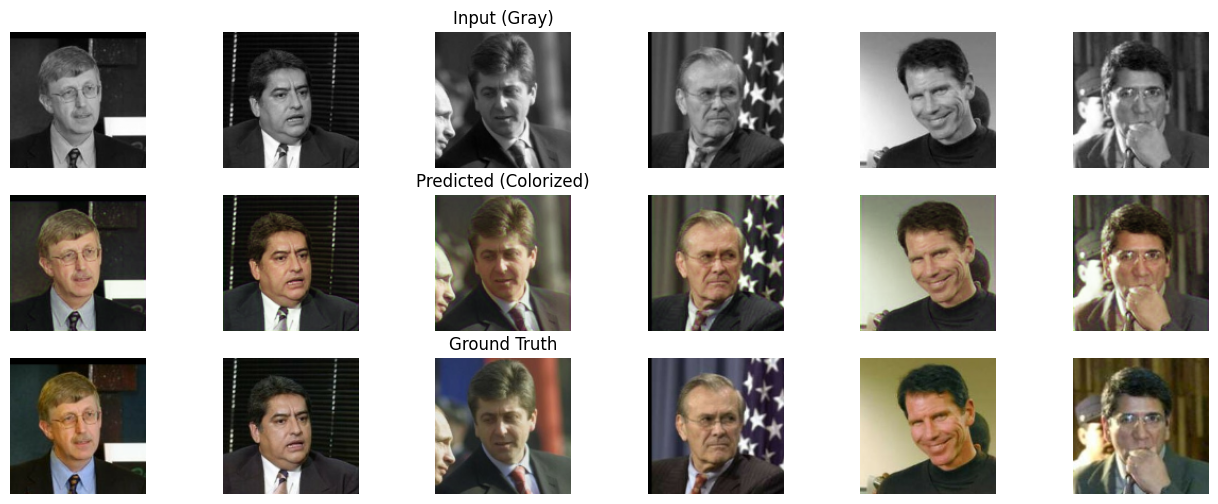

In [7]:
gray_batch, color_batch = next(iter(test_ds))
decoded = autoencoder.predict(gray_batch)

n = 6
plt.figure(figsize=(16,6))
for i in range(n):
    plt.subplot(3,n,i+1); plt.imshow(tf.squeeze(gray_batch[i]), cmap='gray'); plt.axis('off');
    if i==2: plt.title("Input (Gray)")
    plt.subplot(3,n,i+1+n); plt.imshow(decoded[i]); plt.axis('off');
    if i==2: plt.title("Predicted (Colorized)")
    plt.subplot(3,n,i+1+2*n); plt.imshow(color_batch[i]); plt.axis('off');
    if i==2: plt.title("Ground Truth")
plt.show()


# Saving the trained Model:

In [8]:
autoencoder.save("colorizer_dynamic_unet.h5")
print("Model saved as colorizer_dynamic_unet.h5 !!")

Model saved as colorizer_dynamic_unet.h5 !!


# Testing on unseen images:

In [9]:
import math, cv2, numpy as np, matplotlib.pyplot as plt

def pad_to_multiple(img, multiple=8):
    h, w = img.shape[:2]
    new_h = math.ceil(h / multiple) * multiple
    new_w = math.ceil(w / multiple) * multiple
    pad_h = new_h - h
    pad_w = new_w - w
    padded = np.pad(img, ((0, pad_h), (0, pad_w)), mode='reflect')
    return padded, h, w




In [10]:
def colorize_any_image(model, path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Pad grayscale image to multiple of 8
    gray_padded, orig_h, orig_w = pad_to_multiple(gray, 8)
    gray_input = gray_padded.astype("float32") / 255.0
    gray_input = np.expand_dims(gray_input, axis=(0, -1))

    # Predict and crop back
    pred = model.predict(gray_input)
    colorized = np.clip(pred[0][:orig_h, :orig_w], 0, 1)

    # Display results
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(gray, cmap='gray'); plt.title("Grayscale"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(colorized); plt.title("Colorized"); plt.axis("off")
    plt.tight_layout(); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


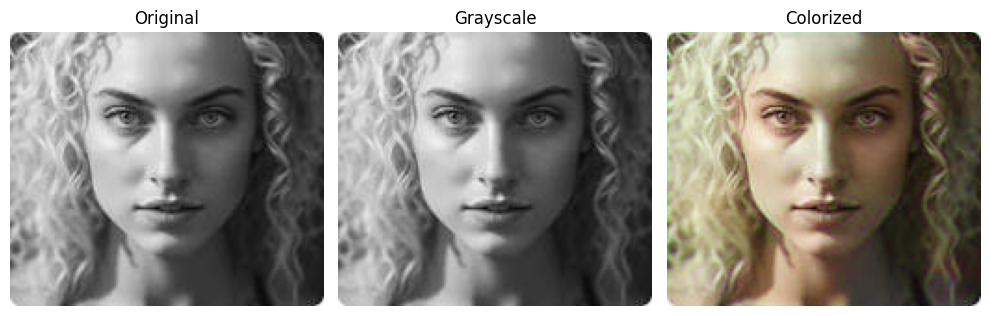

In [11]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/DeepLearningMiniProj/colorizer_dynamic_unet.h5", compile=False)
colorize_any_image(model, "/content/drive/MyDrive/DeepLearningMiniProj/TestImages/download.jpeg")
